In [1]:
import sys
project_path = "/".join(sys.path[0].split("/")[:-1])
sys.path.append(project_path)


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from ale.ale.ale import ALE
from ale.utils.data_operations import get_mids

Download data from: https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv

In [2]:
data = pd.read_csv("../datasets/bike.csv")
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [3]:
X = data.loc[:, ~data.columns.isin(["cnt", "yr", "days_since_2011"])]
feature_names = X.columns
X = X.to_numpy()
y = data["cnt"]
target_name = "cnt"
y = y.to_numpy()

One hot encoding for categorical features

This is especially important as we don't want to bias the model by introducing different distances between categorical features

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
encoder = OneHotEncoder()
encoder.fit(X_train[:, :6])

def encode_features(data):
    categorical = data[:, :6]
    encoded = encoder.transform(categorical).toarray()
    continuous = data[:, 6:].astype(float)
    concat = np.concatenate([encoded, continuous], axis=1)
    return concat.astype(float)

In [6]:
class BikeRentalPredictor:
    def __init__(self) -> None:
        self.model = RandomForestRegressor()

    def fit(self, X, y):
        X_encoded = encode_features(X)
        self.model.fit(X_encoded, y)

    def predict(self, X):
        X_encoded = encode_features(X)
        y_pred = self.model.predict(X_encoded)
        return y_pred

In [7]:
model = BikeRentalPredictor()
model.fit(X_train, y_train)

Text(0.5, 0, 'ground truth')

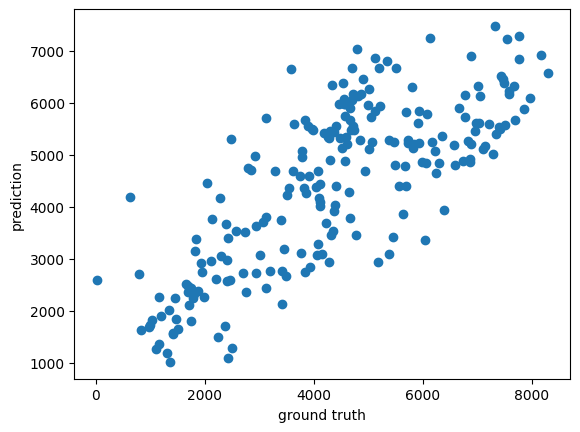

In [8]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_ylabel("prediction")
ax.set_xlabel("ground truth")

In [9]:
models = []
num_models = 20
for _ in range(num_models):
    model = BikeRentalPredictor()
    model.fit(X_train, y_train)
    models.append(model)

In [10]:
ale = ALE(models=models, num_buckets=10)

columns = [6, 7]
scores, bins = ale(X_test, columns)

20it [00:20,  1.02s/it]


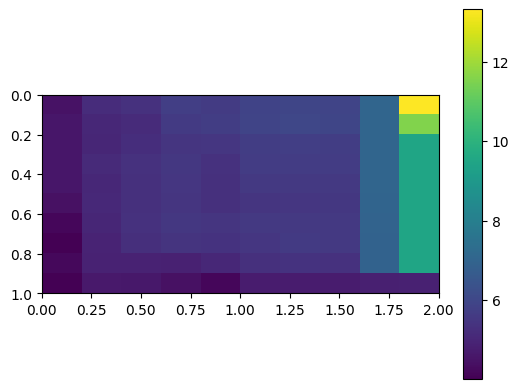

In [16]:
plt.imshow(scores.std(axis=0)[::-1], extent=[0, 2, 1, 0])

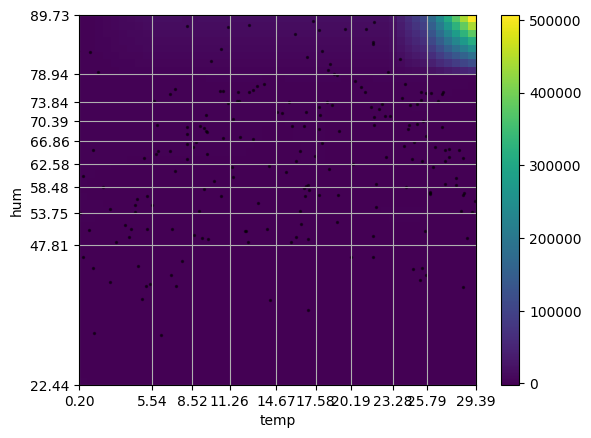

In [12]:
fig, ax = ale.plot_2d(scores, bins, color_bar=True, aspect="auto")
ax.set_xlabel(feature_names[columns[0]])
ax.set_ylabel(feature_names[columns[1]])
ax.grid()

ax.scatter(*X_test[:, columns].T, c="k", alpha=0.5, s=2)

(array([11., 30., 53., 50., 34., 15.,  8., 13.,  4.,  2.]),
 array([ 2.8343814 ,  5.50941536,  8.18444932, 10.85948328, 13.53451724,
        16.2095512 , 18.88458516, 21.55961912, 24.23465308, 26.90968704,
        29.584721  ]),
 <BarContainer object of 10 artists>)

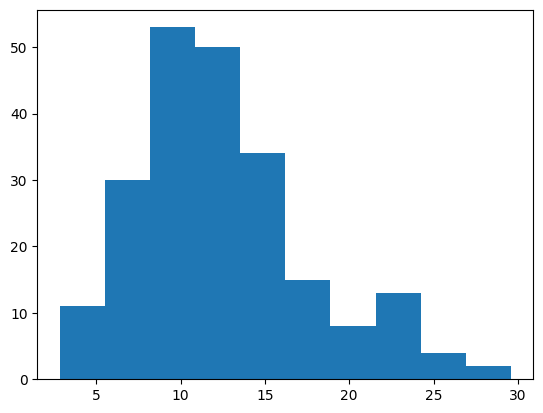

In [13]:
# plt.plot(mids[1], scores[0])

 #plt.hist(X_test[:, 7])
plt.hist(X_test[:, 8])